In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("simulated_transaction_2024.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230596 entries, 0 to 230595
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Date                    230367 non-null  object 
 1   Timestamp               230345 non-null  object 
 2   Account No              230372 non-null  float64
 3   Balance                 230350 non-null  float64
 4   Amount                  230387 non-null  float64
 5   Third Party Account No  6832 non-null    float64
 6   Third Party Name        223517 non-null  object 
dtypes: float64(4), object(3)
memory usage: 12.3+ MB


In [3]:
df.head()

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name
0,01/01/2023,00:00,678330503.0,2971.0,1584.0,NaN,Westport Care Home
1,01/01/2023,00:00,472213568.0,3792.0,1950.0,NaN,Barbiee Boutique
2,01/01/2023,00:00,472213568.0,3012.0,-780.0,283027736.0,NaN
3,01/01/2023,00:00,283027736.0,1787.0,780.0,472213568.0,NaN
4,01/01/2023,00:00,624500124.0,3226.0,1825.0,NaN,Fat Face


In [4]:
positive_count = (df['Amount'] > 0).sum()
negative_count = (df['Amount'] < 0).sum()

print(positive_count)
print(negative_count)

10417
219961


In [5]:
print(df.isnull().sum())

Date                         229
Timestamp                    251
Account No                   224
Balance                      246
Amount                       209
Third Party Account No    223764
Third Party Name            7079
dtype: int64


<ipython-input-6-bbe0d6577b92>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-6-bbe0d6577b92>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_expenses = expenses.resample('M').sum()


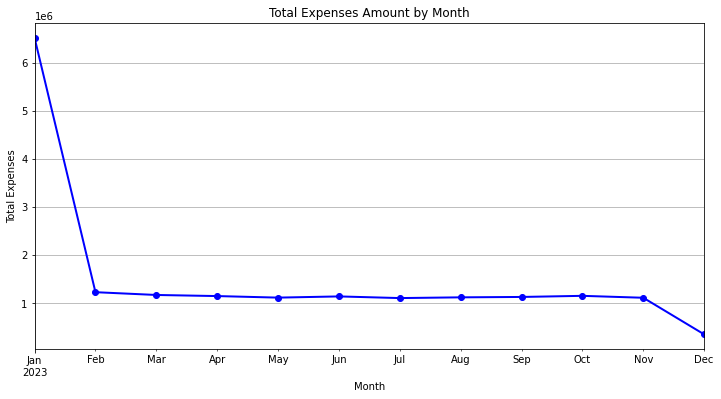

In [6]:
# Visualization of total expenses per month (exclude positive values)
df['Date'] = pd.to_datetime(df['Date'])
expenses = df[df['Amount'] < 0]
expenses.set_index('Date', inplace=True)
monthly_expenses = expenses.resample('M').sum()
monthly_expenses['Amount'] = -monthly_expenses['Amount']

plt.figure(figsize=(12, 6))
monthly_expenses['Amount'].plot(kind='line', marker='o', color='b', linewidth=2)
plt.title('Total Expenses Amount by Month')
plt.xlabel('Month')
plt.ylabel('Total Expenses')
plt.grid(True)
plt.show()

<ipython-input-7-718e9bc856e0>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  january_expenses = expenses['2023-01']
<ipython-input-7-718e9bc856e0>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_january_expenses = january_expenses.resample('D').sum()


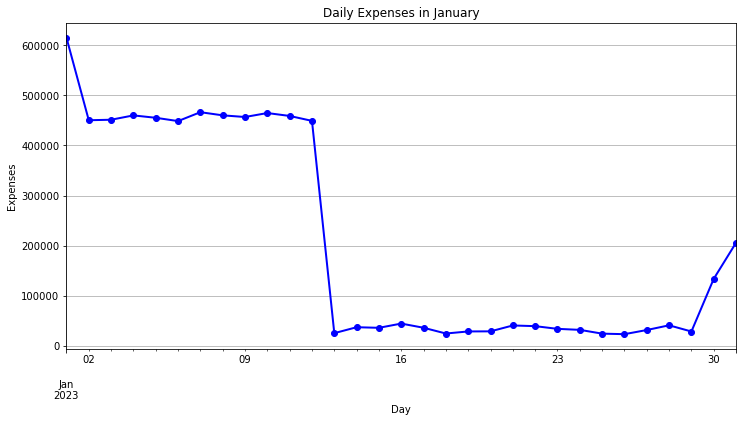

In [7]:
january_expenses = expenses['2023-01']
daily_january_expenses = january_expenses.resample('D').sum()
daily_january_expenses['Amount'] = -daily_january_expenses['Amount']

plt.figure(figsize=(12, 6))
daily_january_expenses['Amount'].plot(kind='line', marker='o', color='b', linewidth=2)
plt.title('Daily Expenses in January')
plt.xlabel('Day')
plt.ylabel('Expenses')
plt.grid(True)
plt.show()

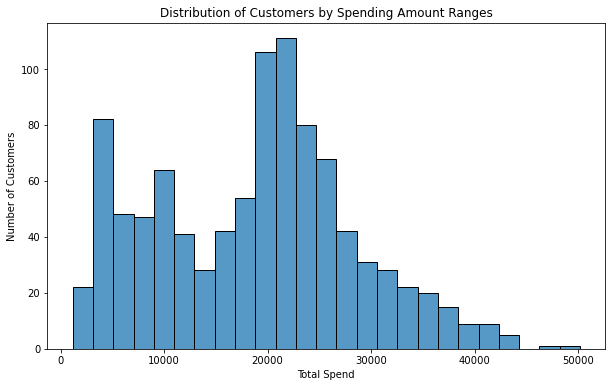

In [8]:
customer_expenses = expenses.groupby('Account No')['Amount'].sum()
customer_expenses = -customer_expenses
customer_expenses = customer_expenses.sort_values()

plt.figure(figsize=(10, 6))
sns.histplot(customer_expenses, bins=25)
plt.title('Distribution of Customers by Spending Amount Ranges')
plt.xlabel('Total Spend')
plt.ylabel('Number of Customers')
plt.show()

8926.37 17634.27 21614.32 26145.22


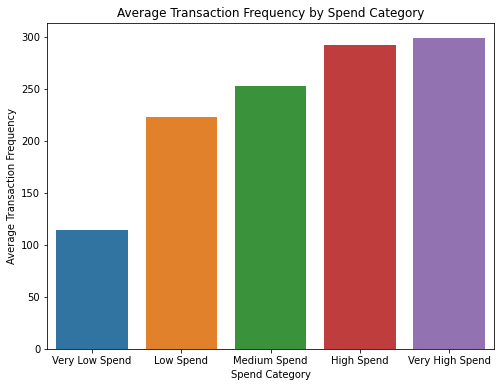

In [9]:
# Visualize the average frequency of transactions per group
transaction_count_per_customer = df.groupby('Account No').size().reset_index(name='transaction_count')

customer_spend = pd.merge(customer_expenses, transaction_count_per_customer, on='Account No')

quantiles = customer_spend['Amount'].quantile([0.2, 0.4, 0.6, 0.8])
threshold1 = quantiles.iloc[0]
threshold2 = quantiles.iloc[1]
threshold3 = quantiles.iloc[2]
threshold4 = quantiles.iloc[3]
print(threshold1,threshold2,threshold3,threshold4)
customer_spend['spend_category'] = pd.cut(customer_spend['Amount'], 
                                          bins=[0, threshold1, threshold2, threshold3, threshold4, customer_spend['Amount'].max()], 
                                          labels=['Very Low Spend', 'Low Spend', 'Medium Spend', 'High Spend', 'Very High Spend'], 
                                          include_lowest=True)

average_transaction_freq = customer_spend.groupby('spend_category')['transaction_count'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=average_transaction_freq.index, y=average_transaction_freq.values)
plt.title('Average Transaction Frequency by Spend Category')
plt.xlabel('Spend Category')
plt.ylabel('Average Transaction Frequency')
plt.show()

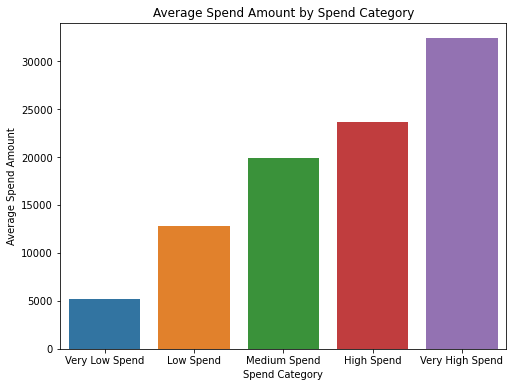

In [10]:
# Calculate the average amount spent by each group
average_spend_per_category = customer_spend.groupby('spend_category')['Amount'].mean()

# Visualize the average amount spent per group
plt.figure(figsize=(8, 6))
sns.barplot(x=average_spend_per_category.index, y=average_spend_per_category.values)
plt.title('Average Spend Amount by Spend Category')
plt.xlabel('Spend Category')
plt.ylabel('Average Spend Amount')
plt.show()

Total Income:  19841151.0
Total Expenses:  18357984.72


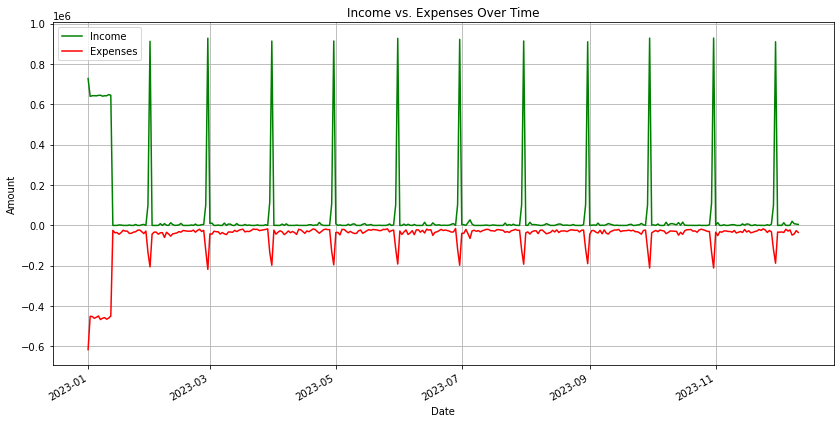

In [11]:
# Classify transactions based on the sign of the transaction amount
df['Transaction Type'] = df['Amount'].apply(lambda x: 'Income' if x >= 0 else 'Expenses')

# Calculate the total amounts for income and expenses
total_income = df[df['Transaction Type'] == 'Income']['Amount'].sum()
total_expenses = abs(df[df['Transaction Type'] == 'Expenses']['Amount'].sum())  # Absolute value for expenses

# Print total income and expenses
print("Total Income: ", total_income)
print("Total Expenses: ", total_expenses)

# Group data by date and transaction type to sum amounts
date_series_data = df.groupby(['Date', 'Transaction Type'])['Amount'].sum().unstack().fillna(0)

# Plot the data
plt.figure(figsize=(14, 7))
date_series_data['Income'].plot(color='green', label='Income')
date_series_data['Expenses'].plot(color='red', label='Expenses')
plt.title('Income vs. Expenses Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

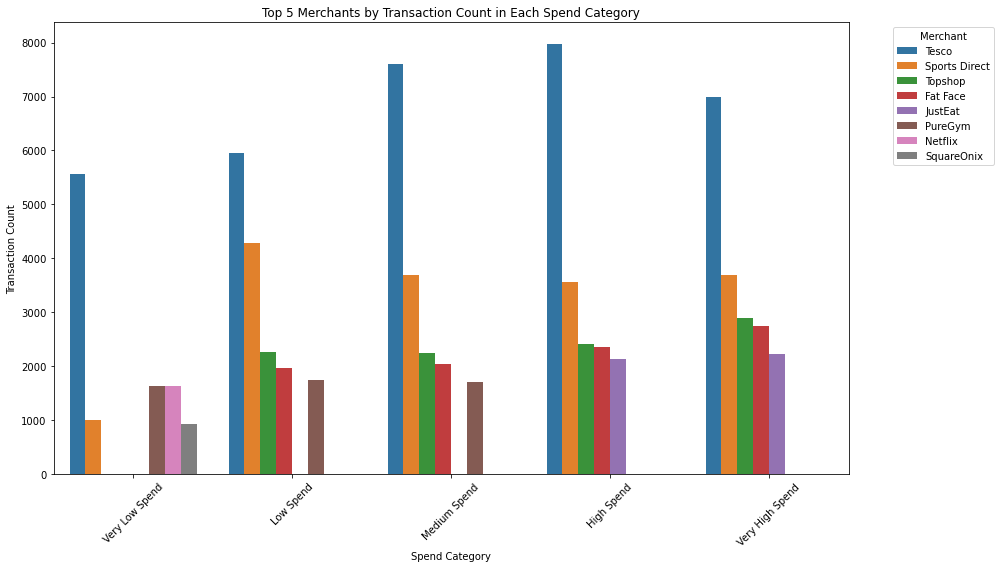

In [12]:
# Top 5 Products or Services by Spend Category
df['Merchant'] = df['Third Party Name'].fillna(df['Third Party Account No'])

df = pd.merge(df, customer_spend[['Account No', 'spend_category']], on='Account No')

merchant_counts = df.groupby(['spend_category', 'Merchant']).size().reset_index(name='Counts')

top_merchants_per_category = merchant_counts.groupby('spend_category').apply(
    lambda x: x.nlargest(5, 'Counts').sort_values('Counts', ascending=False)
).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.barplot(
    x='spend_category', 
    y='Counts', 
    hue='Merchant', 
    data=top_merchants_per_category,
    order=['Very Low Spend', 'Low Spend', 'Medium Spend', 'High Spend', 'Very High Spend'],
    hue_order=top_merchants_per_category.sort_values(by='Counts', ascending=False)['Merchant'].unique()
)
plt.title('Top 5 Merchants by Transaction Count in Each Spend Category')
plt.xlabel('Spend Category')
plt.ylabel('Transaction Count')
plt.legend(title='Merchant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()